In [2]:
station_locations

,long,lat,id,estacion,linea
5,-58.380574,-34.604245,6.0,9 DE JULIO,D
41,-58.436429,-34.618280,42.0,ACOYTE,A
36,-58.401208,-34.609834,37.0,ALBERTI,A
27,-58.431274,-34.602162,28.0,ANGEL GALLARDO,B
15,-58.380611,-34.608983,16.0,AV. DE MAYO,C
...,...,...,...,...,...
7,-58.385142,-34.601587,8.0,TRIBUNALES TEATRO COLON,D
72,-58.466227,-34.584095,73.0,TRONADOR VILLA ORTUZAR,B
21,-58.387296,-34.604094,22.0,URUGUAY,B
67,-58.457892,-34.640137,68.0,VARELA,E


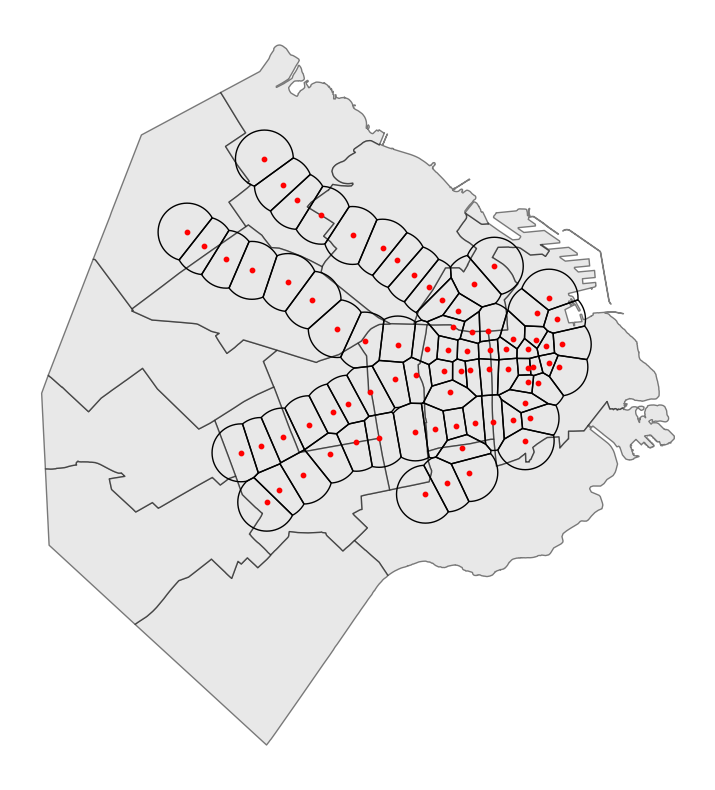

In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.spatial import Voronoi
from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

# Load Buenos Aires boroughs (communes)
communes = gpd.read_file("comunas.shp")

# Detect original CRS (assuming it's EPSG:4326 for lat/lon)
original_crs = communes.crs

# Load subway station locations from .pkl file
with open("BA_Final_Locations.pkl", "rb") as file:
    station_locations = pickle.load(file)

# Convert station locations to a GeoDataFrame
stations_gdf = gpd.GeoDataFrame(
    station_locations,
    geometry=[Point(xy) for xy in zip(station_locations["long"], station_locations["lat"])],
    crs="EPSG:4326"
)

# Convert both datasets to a projected CRS (meters) for Voronoi computation
stations_gdf = stations_gdf.to_crs(epsg=3857)
communes = communes.to_crs(epsg=3857)

# Extract station coordinates
points = np.array(list(zip(stations_gdf.geometry.x, stations_gdf.geometry.y)))

# Ensure at least 4 points for Voronoi computation
if len(points) < 4:
    raise ValueError("Not enough station points to compute Voronoi diagram.")

# Add artificial boundary points for stability
min_x, min_y, max_x, max_y = stations_gdf.total_bounds
boundary_points = np.array([
    [min_x - 1000, min_y - 1000], 
    [min_x - 1000, max_y + 1000], 
    [max_x + 1000, min_y - 1000], 
    [max_x + 1000, max_y + 1000]
])
points = np.vstack([points, boundary_points])

# Compute Voronoi diagram
vor = Voronoi(points)

# Define buffer area around stations
max_distance_m = 1000  # 1 km in meters
station_buffers = stations_gdf.geometry.buffer(max_distance_m)
valid_area = unary_union(station_buffers)

# Generate Voronoi polygons and clip them (preserving station order)
clipped_polygons = []
for point_idx, region_idx in enumerate(vor.point_region):
    if point_idx >= len(stations_gdf):  # Skip artificial points
        continue

    region = vor.regions[region_idx]
    if not region or -1 in region:
        clipped_polygons.append(None)
        continue

    polygon = Polygon([vor.vertices[i] for i in region])
    clipped_polygon = polygon.intersection(valid_area)

    if not clipped_polygon.is_empty and clipped_polygon.is_valid:
        clipped_polygons.append(clipped_polygon)
    else:
        clipped_polygons.append(None)

# Remove None polygons and align with stations
valid_indices = [i for i, poly in enumerate(clipped_polygons) if poly is not None]
stations_gdf = stations_gdf.iloc[valid_indices].reset_index(drop=True)
clipped_polygons = [clipped_polygons[i] for i in valid_indices]

# Create GeoDataFrame
voronoi_gdf = gpd.GeoDataFrame(geometry=clipped_polygons, crs="EPSG:3857")

# Plot Buenos Aires boroughs
fig, ax = plt.subplots(figsize=(10, 10))
communes.plot(ax=ax, color="lightgrey", edgecolor="black", alpha=0.5)

# Plot Voronoi regions (handling MultiPolygons)
for poly in clipped_polygons:
    if poly.geom_type == "Polygon":
        x, y = poly.exterior.xy
        ax.fill(x, y, edgecolor="black", facecolor="none", linewidth=1)
    elif poly.geom_type == "MultiPolygon":
        for sub_poly in poly.geoms:
            x, y = sub_poly.exterior.xy
            ax.fill(x, y, edgecolor="black", facecolor="none", linewidth=1)

# Plot station points
ax.scatter(stations_gdf.geometry.x, stations_gdf.geometry.y, color="red", s=10)

ax.set_axis_off()
plt.show()


In [3]:
communes

,id,objeto,comuna,barrios,perimetro,area,geometry
0,1,COMUNA,1,"CONSTITUCION, MONSERRAT, RETIRO, PUERTO MADERO...",36011.96,17784744.41,"MULTIPOLYGON (((-6497556.719 -4106091.751, -64..."
1,2,COMUNA,2,RECOLETA,21450.47,6317725.62,"POLYGON ((-6498832.76 -4105601.489, -6498835.1..."
2,3,COMUNA,3,"SAN CRISTOBAL, BALVANERA",10486.26,6385991.48,"POLYGON ((-6502385.341 -4109384.6, -6502204.48..."
3,4,COMUNA,4,"BARRACAS, BOCA, PARQUE PATRICIOS, NUEVA POMPEYA",35474.12,21688665.28,"POLYGON ((-6496071.732 -4112282.635, -6496064...."
4,5,COMUNA,5,"ALMAGRO, BOEDO",12323.43,6660603.14,"POLYGON ((-6502491.213 -4111563.827, -6502485...."
5,6,COMUNA,6,CABALLITO,10990.96,6851028.91,"POLYGON ((-6504465.476 -4110607.718, -6504460...."
6,7,COMUNA,7,"FLORES, PARQUE CHACABUCO",17972.26,12422900.83,"POLYGON ((-6506846.416 -4113678.027, -6506799...."
7,8,COMUNA,8,"VILLA LUGANO, VILLA RIACHUELO, VILLA SOLDATI",20943.00,22218817.04,"POLYGON ((-6506527.687 -4116576.219, -6506493...."
8,9,COMUNA,9,"PARQUE AVELLANEDA, MATADEROS, LINIERS",21411.74,16505305.78,"POLYGON ((-6514333.314 -4114119.735, -6514314...."
9,10,COMUNA,10,"FLORESTA, MONTE CASTRO, VELEZ SARSFIELD, VERSA...",18332.04,12656556.95,"POLYGON ((-6510891.839 -4112381.421, -6510876...."


In [8]:
# Ensure the Voronoi GeoDataFrame is in the original CRS before saving
voronoi_gdf = voronoi_gdf.to_crs(original_crs)

# Define output file path
output_path = "BA_Voronoi_File_1km.shp"

# Save the Voronoi polygons as a Shapefile
voronoi_gdf.to_file(output_path, driver="ESRI Shapefile")

print(f"Voronoi diagram saved to {output_path}")

Voronoi diagram saved to BA_Voronoi_File_1km.shp
